In [2]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import os
import json
import glob
import gzip
import itertools
import numpy as np
import collections
import networkx as nx
import matplotlib as mpl
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import matplotlib.font_manager as font_manager
import string
import pickle


DIR = "./"
PATH_TIME_SERIES_SRC = DIR + "_raw_df_timeseries.tsv.gz"
PATH_TIME_SERIES_DST = DIR + "df_timeseries_en.tsv.gz"
PATH_CHANNELS_SRC = DIR + "_raw_df_channels.tsv.gz"
PATH_CHANNELS_DST = DIR + "df_channels_en.tsv.gz"
PATH_INVALID = DIR + "invalid.csv"
PATH_METADATA_SRC = DIR + "_raw_yt_metadata.jsonl.zst"
PATH_METADATA_NON_ENGLISH = DIR + "yt_metadata_fil.jsonl.gz"
PATH_METADATA_DEDUP = DIR + "yt_metadata_en_dd/{}.jsonl.gz"
PATH_METADATA_DST = DIR + "yt_metadata_en.jsonl (1).gz"
PATH_METADATA_HELPER = DIR + "yt_metadata_helper.feather"

In [3]:
categories = ['Sports',
 'People & Blogs',
 'Howto & Style',
 'News & Politics',
 'Autos & Vehicles',
 'Travel & Events',
 'Film & Animation',
 'Entertainment',
 'Music',
 'Nonprofits & Activism',
 'Pets & Animals',
 'Science & Technology',
 'Comedy',
 'Gaming',
 'Education']

upload_periods = pd.to_datetime(np.arange(np.datetime64("2005-05"), np.datetime64("2019-11"), np.timedelta64(1, 'M')))
upload_periods = [str(period.strftime('%Y-%m-%d')) for period in upload_periods]

START_YEAR = 2005
END_YEAR = 2019


## Tags on Trends


In this project, we want to focus on the usage of tags in Youtube videos. With this goal, we aim to investigate:
* the evolution of tags over time. We want to check if real-life events cause sudden increases in the usage of some "trendy" tags.
* relationships between tags. We want to create a graph network of tags such that tags used in common videos will be connected with an edge.
* misuse of tags. We aim to identify misused tags that are irrelevant to other tags of the video and merely used to gain "viewership", we expect these tags to be popular at that time frame. We aim to use tag graphs to identify such misuses.  

To answer this goal, we will first focus on plotting some descriptive statistics that might uncover interesting results about the data:
* Distribution of the number of videos
* Distribution of the number of tags in a video
* Distribution of the number of edges in the tag network
* Distribution of sparsity in tag network

Moreover, we will investigate the feasibility of our approach using a case study.

###Distribution of number of videos  

The number of videos per category and the evolution of the number of videos might be important for our approach and therefore should be investigated. Since reading the whole data is unfeasible, we might read the data by chunks and store the monthly video count.

In [ ]:
num_videos_by_category = None
for df_json in tqdm.tqdm(pd.read_json(PATH_METADATA_DST, compression="infer", chunksize=500000, lines=True)):
    df_json["upload_date"] =  pd.to_datetime(pd.to_datetime(df_json["upload_date"]).dt.date)
    df_json = df_json[df_json["categories"]!=""]
    chunk_statistics = df_json[["categories","upload_date","display_id"]].groupby(
        ["categories",df_json["upload_date"].dt.year,df_json["upload_date"].dt.month]
    )["display_id"].count()
    chunk_statistics.index.rename("year",level=1,inplace=True)
    chunk_statistics.index.rename("month",level=2,inplace=True)
    if num_videos_by_category is not None:
      num_videos_by_category = num_videos_by_category.merge(chunk_statistics,on=["categories","year","month"],how="outer")
      num_videos_by_category = num_videos_by_category.fillna(0)
      num_videos_by_category = pd.DataFrame(num_videos_by_category.sum(axis=1))
    else:
      num_videos_by_category = pd.DataFrame(chunk_statistics)

146it [45:20, 18.63s/it]


In [ ]:
num_videos_by_category

num_videos
categories       year month            
Autos & Vehicles 2007 1           319.0
                      2           299.0
                      6           593.0
                      9           840.0
                      10          892.0
...                                 ...
Howto & Style    2005 12            3.0
People & Blogs   2019 11            1.0
Howto & Style    2005 9             1.0
Pets & Animals   2005 9             1.0
Sports           2005 5             1.0

[2536 rows x 1 columns]

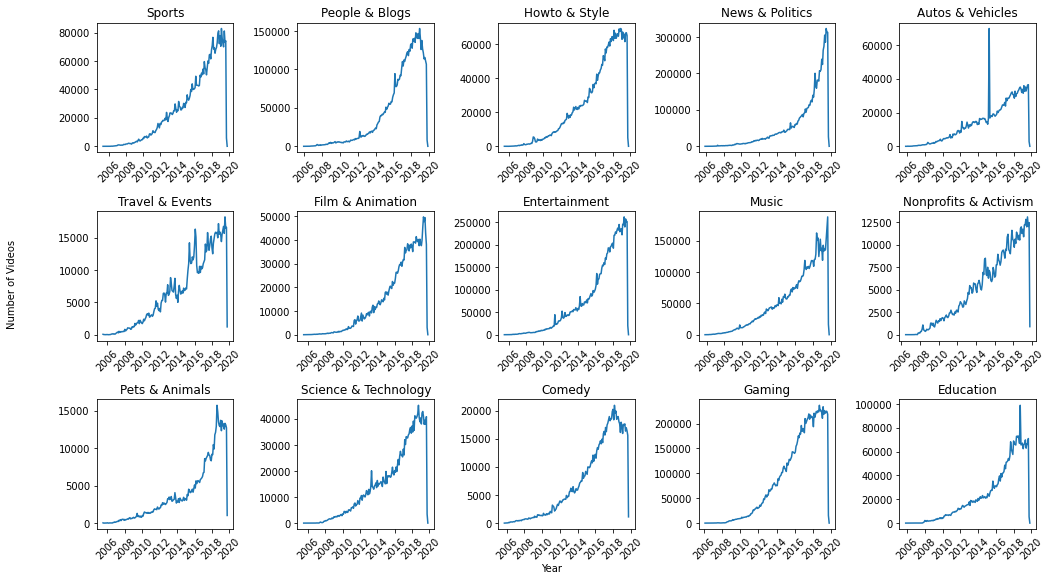

In [ ]:
num_videos_by_category_monthly = num_videos_by_category.rename(columns={0:"num_videos"})
num_videos_by_category_monthly = num_videos_by_category.reset_index(level=[1,2])
num_videos_by_category_monthly['Date'] = pd.to_datetime(num_videos_by_category_monthly['year'].astype(str) + ' ' + num_videos_by_category_monthly['month'].astype(str))
num_videos_by_category_monthly = num_videos_by_category_monthly.set_index('Date',append=True)

fig, axs = plt.subplots(3,5,figsize=(14,8))

for i in range(3):
  for j in range(5):
    ax = axs[i,j]
    data = num_videos_by_category_monthly.loc[categories[i*5+j]]
    data = data.sort_index()
    ax.plot(data.index,data["num_videos"])
    ax.set_title(categories[i*5+j])
    ax.tick_params('x', labelrotation=45) 
fig.text(0.5, 0, 'Year', ha='center')
fig.text(-0.04, 0.5, 'Number of Videos', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

As can be seen from the graph, the number of videos increased almost exponentially, as Youtube became a popular platform. There are very few videos uploaded in earlier years, which might cause our observations to be inaccurate since there are few videos that might focus on only a few topics and might limit the generalizability of tags.

We can also observe a sudden drop towards the end of 2019, which might be the result of the crawling mechanism at that period.

### Distribution of number of tags <a class="anchor" id="first"></a>

It might also be helpful to see the distribution of the number of tags per video to have an idea about the size of the tag networks.

In [ ]:
# change string of tags separated by "," to set of tags, removing punctuation
def tags_to_set(row):
  if row!="":
    return set([s.translate(str.maketrans('', '', string.punctuation)) for s in row.lower().split(",")]) 
  else:
    return {}

In [ ]:
num_tags_by_category = None
for df_json in tqdm.tqdm(pd.read_json(PATH_METADATA_DST, compression="infer", chunksize=500000, lines=True)):
    df_json["num_tags"] = df_json["tags"].apply(lambda x: len(tags_to_set(x)))
    df_json["upload_date"] =  pd.to_datetime(pd.to_datetime(df_json["upload_date"]).dt.date)
    df_json = df_json[df_json["categories"]!=""]
    chunk_statistics = df_json[["categories","num_tags","upload_date","display_id"]].groupby(
        ["categories",df_json["upload_date"].dt.year,df_json["upload_date"].dt.month,"num_tags"]
    )["display_id"].count()
    chunk_statistics.index.rename("year",level=1,inplace=True)
    chunk_statistics.index.rename("month",level=2,inplace=True)
    if num_tags_by_category is not None:
      num_tags_by_category = num_tags_by_category.merge(chunk_statistics,on=["categories","year","month","num_tags"],how="outer")
      num_tags_by_category = num_tags_by_category.fillna(0)
      num_tags_by_category = pd.DataFrame(num_tags_by_category.sum(axis=1))
    else:
      num_tags_by_category = pd.DataFrame(chunk_statistics)

146it [42:04, 17.29s/it]


In [ ]:
num_tags_by_category

0
categories       year month num_tags      
Autos & Vehicles 2007 1     4         16.0
                            7         33.0
                            9         22.0
                      2     11         8.0
                      6     20        35.0
...                                    ...
Sports           2008 5     40         1.0
                            41         1.0
                      8     53         1.0
                 2012 5     80         1.0
Travel & Events  2008 4     39         1.0

[168694 rows x 1 columns]

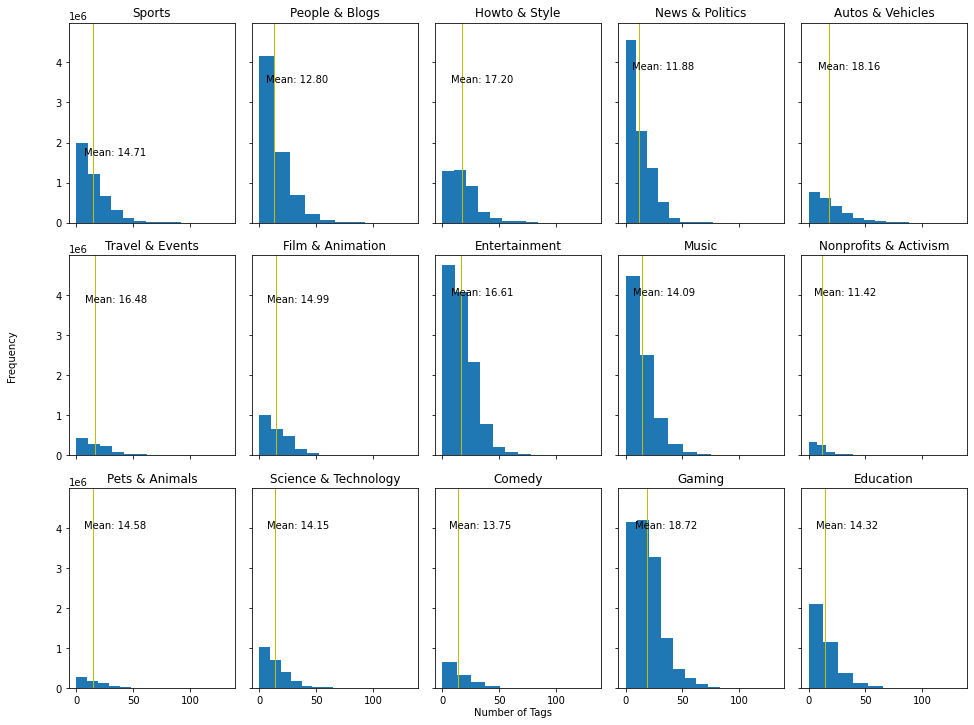

In [ ]:
num_tags_by_category_all_dates = num_tags_by_category.rename(columns={0:"num_occurences"})
num_tags_by_category_all_dates = num_tags_by_category_all_dates.reset_index(level=[1,2,3])

fig, axs = plt.subplots(3,5,figsize=(13,10),sharex=True,sharey=True)

for i in range(3):
  for j in range(5):
    ax = axs[i,j]
    data = num_tags_by_category_all_dates.loc[categories[i*5+j]]
    ax.hist(data["num_tags"],weights=data["num_occurences"])
    ax.set_title(categories[i*5+j])
    mean_occurences = sum(data["num_tags"]*data["num_occurences"])/sum(data["num_occurences"])
    ax.axvline(mean_occurences, color='y', linewidth=1)
    _, max_ = ax.get_ylim()
    ax.text(mean_occurences - mean_occurences/1.8, max_ - max_/5, 'Mean: {:.2f}'.format(mean_occurences))
fig.text(0.5, 0, 'Number of Tags', ha='center')
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

We can see that the average number of tags per video ranges from 11 to 18 and there are some variations between categories. "Gaming" and "Autos & Vehicles" have more tags than other categories.

"Gaming", "Music", and "Entertainment" also have larger frequencies than other categories, confirming that indeed these are the most popular categories on Youtube.

Moreover, we might also plot the evolution of the number of tags by time for each category. To get a better plot, we can limit the data between 2007 and October 2019, since we observed few videos outside this range, which might hurt the visualization.

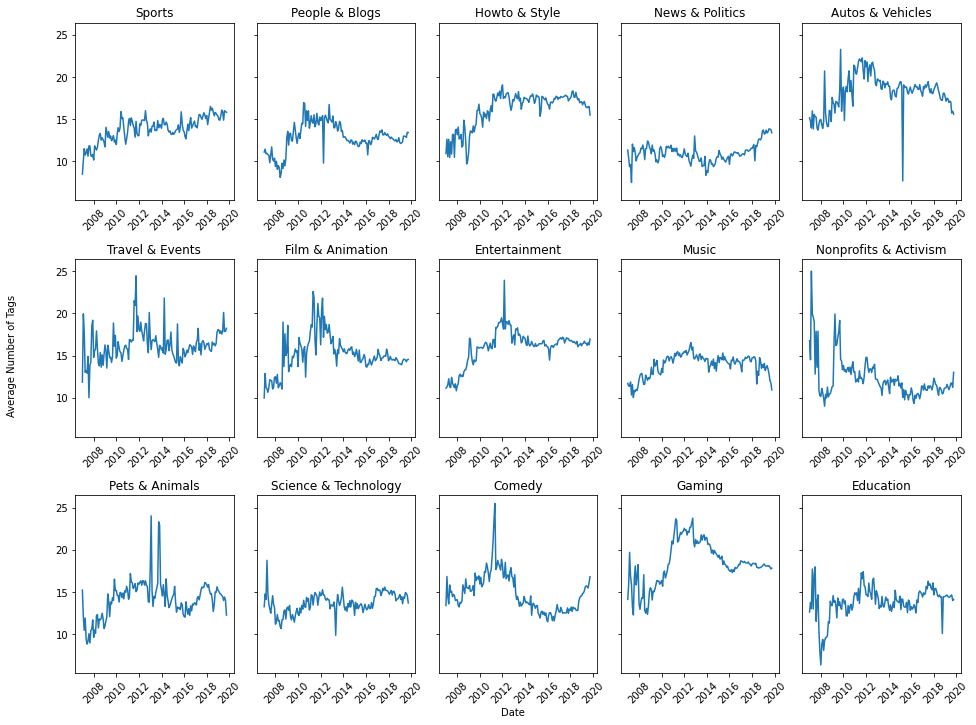

In [ ]:
num_tags_by_category_monthly = num_tags_by_category.rename(columns={0:"num_occurences"})
num_tags_by_category_monthly = num_tags_by_category_monthly.reset_index(level=[1,2,3])

num_tags_by_category_monthly['Date'] = pd.to_datetime(num_tags_by_category_monthly['year'].astype(str) + ' ' + num_tags_by_category_monthly['month'].astype(str))
num_tags_by_category_monthly = num_tags_by_category_monthly.set_index('Date',append=True)

fig, axs = plt.subplots(3,5,figsize=(13,10),sharey=True)

for i in range(3):
  for j in range(5):
    ax = axs[i,j]
    data = num_tags_by_category_monthly.loc[categories[i*5+j]]
    data = data.groupby(["Date"]).apply(lambda x:pd.Series({
        "average":sum(x["num_tags"]*x["num_occurences"])/sum(x["num_occurences"])
    }))
    data = data[(data.index >= "2007-01-01") & (data.index <= "2019-10-01")]
    ax.plot(data.index,data["average"])
    ax.set_title(categories[i*5+j])
    ax.tick_params('x', labelrotation=45) 
fig.text(0.5, 0, 'Date', ha='center')
fig.text(-0.04, 0.5, 'Average Number of Tags', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

We can notice a lot of variance between years for almost every category. 

### Tag Graphs



While we can discover popular tags by just looking at the frequency of the tag, it does not give an idea of "how" the usage of the tag change. It may still be used with the same tags, but just more frequently. Given, we are especially focused on how other tags used with the "trend" tags change as the tag becomes popular, we should focus more on the relationships with neighbor tags, before, during, and after popularity.   

For this problem, a graph is the natural choice of data structure given it can easily capture the usage of tags together in terms of edge weights. To create our graphs, we use each tag as a node and increase the weight between nodes when they are used together in a video.  

We can now focus on the characteristics of the tag networks.

Since our data cannot fit into memory, we read the data chunk by chunk. However, since we use Google Colab and it has a time limit, we cannot process the whole data at once. To be able to continue from where we left off, we save the chunks as separate JSON files, with only columns we are interested in such as "category", "tags" and "upload_date". Given we are not interested in daily numbers, we only take year and month information from the "upload_date" column.

As we read each chunk, we slowly create dictionaries containing counts for tag pairs used together. We create dictionaries for each category and upload date pairs, by forming edges using combinations of tags used together in a video.

In [ ]:
def get_edges(df,edges):
  for i, row in df.iterrows():
    tags = row["tags"]
    pairs = list(itertools.combinations(tags,2))
    for pair in pairs:
      # Since undirected, all pairs contain the tag with smaller lexicographic order at the first index
      key_value = (pair[0],pair[1]) if pair[0]<pair[1] else (pair[1],pair[0])
      if key_value in edges.keys():
        edges[key_value] = edges[key_value] + 1
      else:
        edges[key_value] = 1

In [ ]:
def merge_dictionary(x):
  category = x["categories"].iloc[0]
  upload_date = x["upload_date"].iloc[0]
  dir_path = f"data/{category}"
  if not os.path.exists(dir_path):
      os.makedirs(dir_path)
  edges = {}
  if os.path.exists(f"{dir_path}/{category}_{upload_date}.pkl"):
      with open(f"{dir_path}/{category}_{upload_date}.pkl","rb") as pkl_file:
        edges = pkl.load(pkl_file)

  # add edges from new chunk to the existing dictionary created using previous chunks
  get_edges(x,edges)

  with open(f"{dir_path}/{category}_{upload_date}.pkl","wb") as pkl_file:
    pkl.dump(edges, pkl_file, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
# Read each chunk, process and store the resulting chunk
index = 0
for df_json in tqdm.tqdm(pd.read_json(PATH_METADATA_DST, compression="infer", chunksize=500000, lines=True)):
    df_json["tags"] = df_json["tags"].apply(lambda x: tags_to_set(x))
    df_json["upload_date"] =  pd.to_datetime(df_json["upload_date"])
    df_json["upload_date"] = pd.to_datetime(df_json['upload_date'].dt.year.astype(str) + ' ' + df_json['upload_date'].dt.month.astype(str))
    df_json["upload_date"] = df_json["upload_date"].astype(str)
    df_json = df_json[["categories","display_id","upload_date","tags"]]
    index += 1
    df_json.to_json(f"data_chunks/data_{index}.json")

In [ ]:
# Read each processed chunk, create edge dictionaries 
for json_file in tqdm.tqdm([fname for fname in os.listdir("data_chunks/") if fname.endswith('.json')]):
    df_json = pd.read_json(os.path.join("data_chunks",json_file), compression="infer")
    df_json.groupby(["categories","upload_date"]).apply(merge_dictionary)

#### Distribution of number of edges

We can also plot the average number of edges each node has in the graph using the prepared dictionaries. This graph basically shows the average degree of nodes with time.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


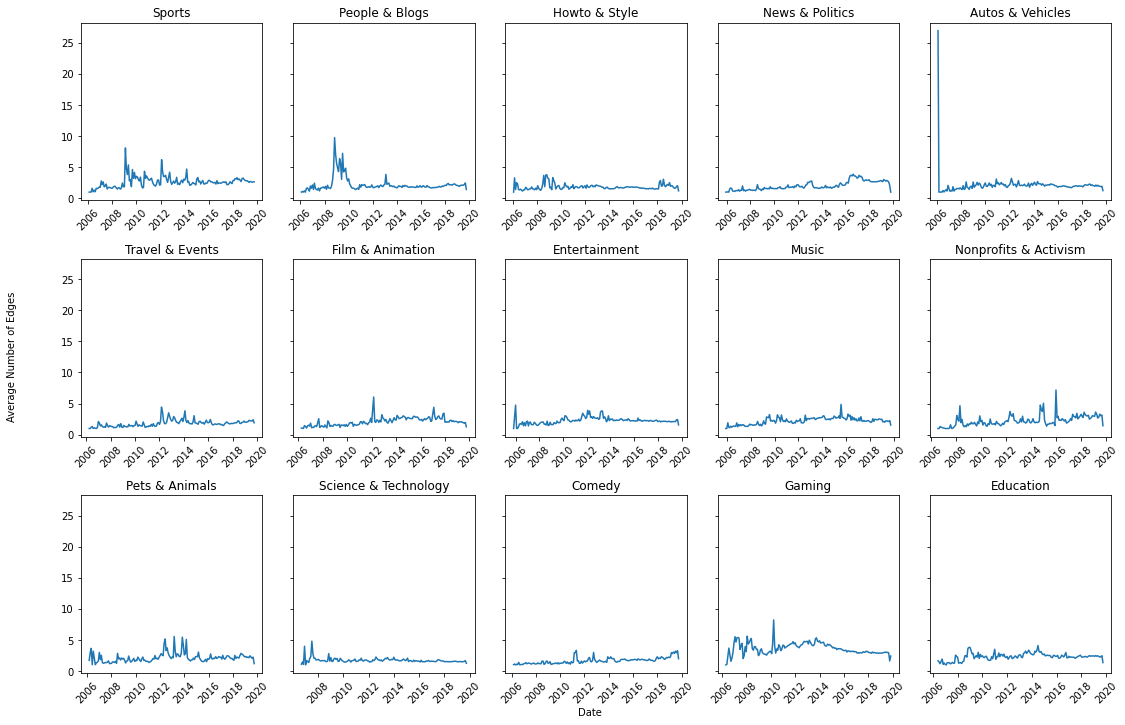

In [ ]:
fig, axs = plt.subplots(3,5,figsize=(15,10),sharey=True)

for i in range(3):
  for j in range(5):
    ax = axs[i,j]
    category = categories[i*5+j]
    data = []
    for fname in sorted([fname for fname in os.listdir(f"./data/{category}") if fname.endswith('.pkl')]):
      with open(os.path.join(f"./data/{category}/",fname),"rb") as pkl_file:
        edges = pkl.load(pkl_file)
        period = fname.split("_")[1][:-4]
        observation = {
            "period":period,
            "average_edges":np.mean(list(edges.values()))
            }
        data.append(observation)
    data = pd.DataFrame(data)
    data["period"] = pd.to_datetime(data["period"])
    data = data.set_index("period")
    ax.plot(data.index,data["average_edges"])    
    ax.set_title(category)
    ax.tick_params('x', labelrotation=45) 

fig.text(0.5, 0, 'Date', ha='center')
fig.text(-0.04, 0.5, 'Average Number of Edges', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

The average number of edges changes between 5-10 per node which is probably very low compared to the number of tags. This gives the intuition that graphs are very sparse. To confirm this intuition we also plot density as:
$\frac{\text{# connections}}{\text{# possible connections}}$ where $\text{# possible connections} = {\text{# nodes} \choose 2}$

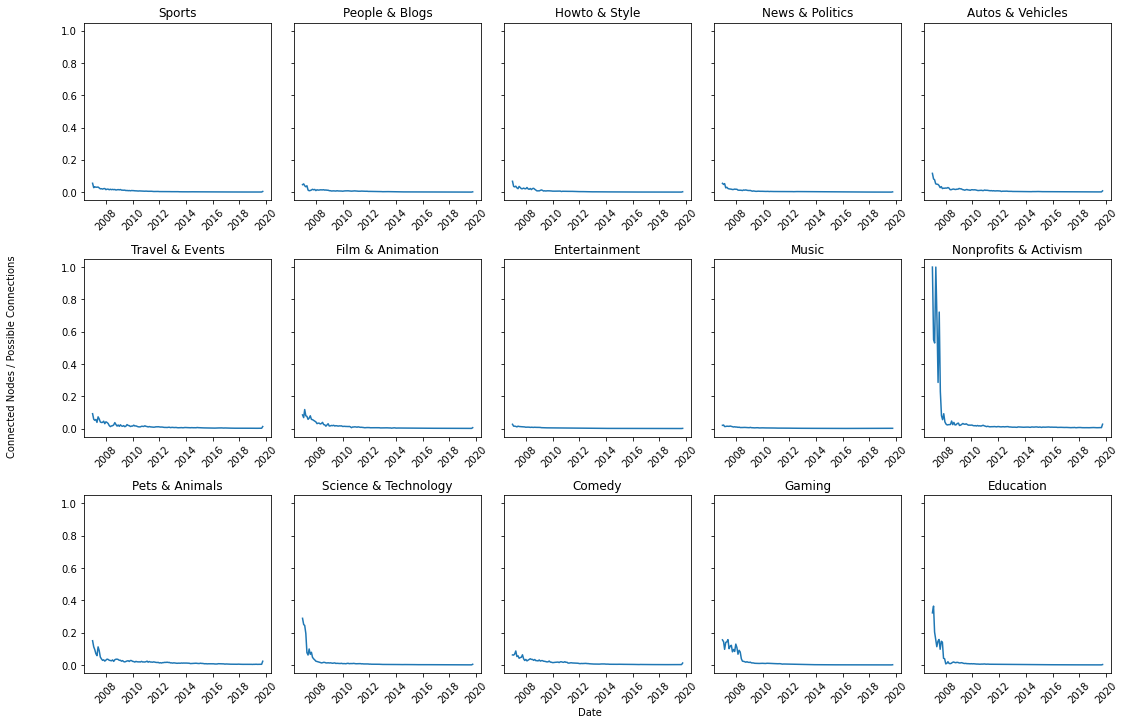

In [16]:
fig, axs = plt.subplots(3,5,figsize=(15,10),sharey=True)

for i in range(3):
  for j in range(5):
    ax = axs[i,j]
    category = categories[i*5+j]
    data = []
    for fname in sorted([fname for fname in os.listdir(f"./data/{category}") if fname.endswith('.pkl')]):
      with open(os.path.join(f"./data/{category}/",fname),"rb") as pkl_file:
        edges = pkl.load(pkl_file)

        num_of_connections = len(edges)
        unique_tags = set()
        for tag_edge in edges.keys():
          tag0, tag1 = tag_edge
          unique_tags.add(tag0)
          unique_tags.add(tag1)

        num_possible = len(unique_tags)/2 * (len(unique_tags) - 1)
        if num_possible == 0:
          density = 0
        else:
          density = num_of_connections / num_possible
        period = fname.split("_")[1][:-4]
        observation = {
            "period":period,
            "density":density
            }
        data.append(observation)
    data = pd.DataFrame(data)
    data["period"] = pd.to_datetime(data["period"])
    data = data.set_index("period")
    data = data[(data.index >= "2007-01-01") & (data.index <= "2019-10-01")]
    ax.plot(data.index,data["density"])    
    ax.set_title(category)
    ax.tick_params('x', labelrotation=45) 

fig.text(0.5, 0, 'Date', ha='center')
fig.text(-0.04, 0.5, 'Connected Nodes / Possible Connections', va='center', rotation='vertical')
fig.tight_layout()
plt.show()

We can see that density remains close to zero for all categories after initial periods where the number of videos is low which indeed confirms that graphs are sparse.

## Case Study:  Popularity of Olympics in the Sports Category

Given the size of the dataset, we wanted to see if we can see trend effects on a subset of videos, specific videos with the "Sports" category, considering it does not overlap much with other categories and has a relatively small size.  
We decided to use the **Olympics** as the trending topic. It is an important event every country in the world participates and given it is repeated every 4 years, it may be possible to see effects three different times in our dataset, 2008, 2012, and 2016.

In [9]:
RELATED_TAG = "olympics"

### Popularity of Olympics

We first focus on the popular tags of the "Sports" category by time. We want to check if we can see Olympics-related tags during the periods of the olympics.

To ease the analysis, we created a separate data frame by filtering only the videos labeled with the "Sports" category, by traversing the chunks one by one. 

In [ ]:
def filter_category(file_path, category, category_path):
    category_df = []

    for df_json in pd.read_json(file_path, compression="infer", chunksize=30000, lines=True):
      cats = df_json[df_json["categories"] == category]
      category_df.append(cats)
    
    category_df = pd.concat(category_df)
    category_df.to_csv(category_path)

In [ ]:
filter_category(PATH_METADATA_DST, "Sports", "sports.csv")

In [ ]:
sports_df = pd.read_csv("sports.csv")
# fix videos with no tag
sports_df["tags"]= sports_df["tags"].fillna('')

We first check the number of videos with tags containing the word "olympics". 

In [ ]:
olympics = sports_df[sports_df['tags'].str.contains(RELATED_TAG)].copy()

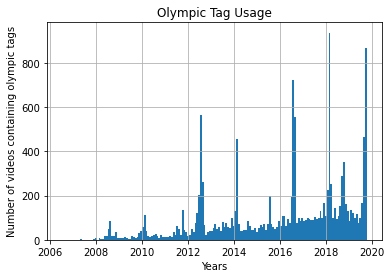

In [ ]:
olympics["upload_date"] = olympics["upload_date"].apply(pd.to_datetime)
olympics.hist(column='upload_date', bins = 14*12)
plt.title("Olympic Tag Usage")
plt.xlabel("Years")
plt.ylabel("Number of videos containing olympic tags") 
plt.show()

As expected, we observe a spike in the videos containing related tags approximately every 2 years, in alignment with the winter and summer Olympics. However, although unlikely, this may be related to a sudden increase in the overall video count. This histogram shows the absolute frequency but what we are focused on is the relative frequency compared to other tags.  

Word clouds, visualizations showing the words with sizes proportional to their relative frequency, are great tools to see the relative popularity of the Olympics.  

We found a visualization tool [WordSwarm](https://github.com/thisIsMikeKane/WordSwarm) later updated by [PetrKorab](https://github.com/PetrKorab/Animated-Word-Cloud-in-Economics). This tool creates video frames using the frequency of the words and plots the word clouds for each period. This allows us to see the evolution of the popular tags. Since we also want to see the most used tags, it is very useful in our case.



In [ ]:
# install the necessary libraries
!pip install beautifulsoup4
!pip install pyglet
!pip install pygame
!pip install Box2D
!pip install ffmpeg-python
!pip install imageio==2.4.1

In [ ]:
# count the number of times each tag is used
def count_tags(df,tag_counts):
  upload_date = df["upload_date"].iloc[0]
  for i, row in df.iterrows():
    tags = row["tags"]
    for tag in tags:
      if (tag,upload_date) in tag_counts.keys():
        tag_counts[(tag,upload_date)] += 1
      else:
        tag_counts[(tag,upload_date)] = 1

In [ ]:
tag_counts = {}
for chunk in pd.read_csv("./sports.csv",usecols=["categories","tags","upload_date"],chunksize=100000):
  chunk["tags"] = chunk["tags"].fillna("")
  chunk["tags"] = chunk["tags"].apply(tags_to_set)
  chunk["upload_date"] =  pd.to_datetime(chunk["upload_date"])
  chunk["upload_date"] = pd.to_datetime(chunk['upload_date'].dt.year.astype(str) + ' ' + chunk['upload_date'].dt.month.astype(str))
  chunk["upload_date"] = chunk["upload_date"].astype(str)
  chunk.groupby("upload_date").apply(lambda x: count_tags(x,tag_counts))

In [ ]:
popular_words = set()

rows = []

for (tag, date) in tag_counts.keys():
  count = tag_counts[(tag, date)]

  data = dict()
  data["tag"] = tag
  data["date"] = date
  data["count"] = count

  rows.append(data)

pop_df = pd.DataFrame(rows)

In [ ]:
# To make the visualization more clear, we only get the most popular 30 tag per month.
sorted_data = pop_df.sort_values(["count"],ascending=[False]).groupby("date").head(30)

In [ ]:
%cd  WordSwarm/2-WordSwarm/

/content/WordSwarm/2-WordSwarm


In [ ]:
word_data = sorted_data.pivot(index='tag', columns='date', values='count')
word_data = word_data.fillna(0)
word_data = word_data.astype(int)

def new_name(old):
  splitted = old.replace("-","/").split("/")
  new_order = [splitted[1],splitted[2], splitted[0]]
  return "/".join(new_order)

old_names = word_data.columns.tolist()
new_names = [new_name(x) for x in old_names]

def rename_column_name(df, old_column_list, new_column_list): 
  df = df.rename(columns=dict(zip(old_column_list, new_column_list))) 
  return df 
                                                                                                                                                                                                  
word_data = rename_column_name(word_data,old_names,new_names)  

word_data *= word_data.to_numpy().max()/word_data.max(axis=0)
word_data = word_data.astype(int)
word_data = word_data.reset_index()

word_data.to_csv("sports_time_table.csv")

In [ ]:
os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
!python wordSwarm.py -i sports_time_table.csv -t "Most Popular Tags in Sports Category by Time"

pygame 2.1.2 (SDL 2.0.16, Python 3.7.15)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading Animated Word Cloud: Research trends in economics...
Initializing pygame framework...
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4528:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5007:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM default
Reading csv: sports_time_table.csv
WordSwarm title: Most Popular Tags in Sports Category by Time
WordSwarm animation com

In [ ]:
from moviepy.editor import *
from IPython.display import Video, HTML
from base64 import b64encode

clip = ImageSequenceClip('../postprocessing/frames/', fps=25)
clip.write_videofile("movie.mp4") 
Video("movie.mp4")

mp4 = open('movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

[![](https://github.com/epfl-ada/ada-2022-project-stuckoverflow/blob/main/figures/thumbnail.png?raw=true)](https://drive.google.com/file/d/1-rYRuiiHMzSUtf9zgNV3TmrUluXinNv-/view?usp=share_link "")

We can observe tags such as "olympics" around July and August of 2008, 2012, and 2016. We specifically see tags such as "london 2012" and "london" in 2012. And "rio 2016" in 2016.  

We even observe tags for the Winter Olympics in 2014 even though it is not as popular as the Summer Olympics.  

Considering we now observed that indeed "olympics" is gaining popularity at these periods, we focus on its relationships with other tags.

### Relationship of Olympics With Other Tags

While our initial analysis shows an increase in the usage of "olympic" tags, this does not give us an idea of how the usage of the tag changed. It may still be used with the same tags, but just more frequently. 

For the scope of this milestone, we create a graph for each year between 2005 and 2019 with videos of the sports category. To create graphs, we use the **networkx** library.

In [ ]:
for year in range(START_YEAR, END_YEAR+1):
  year_data = sports_df[sports_df["upload_date"].dt.year == year]
  year_data["tags"]= year_data["tags"].fillna('')
  year_data["tags"] = year_data["tags"].apply(tags_to_set)

  g = nx.Graph()

  for i, row in year_data.iterrows():
    tags = row["tags"]

    # get pair of tags used together
    pairs = list(itertools.combinations(tags,2))

    for pair_0, pair_1 in pairs:
      if g.has_edge(pair_0,pair_1):
        g[pair_0][pair_1]['weight'] = g[pair_0][pair_1]['weight'] + 1
      else:
        g.add_edge(pair_0,pair_1, weight=1)

  # save each years graph for future analysis
  pickle.dump(g, open(f'./graphs/{year}.pickle', 'wb'))

One important point is that for the remainder of the analysis we will only consider the tag "olympics", however, this approach does not exactly reflect the trend topic Olympics. There may be other similar tags such as "olympic games", "rio olympics 2016", there may even be typos. The use of natural language also increases the complexity of the graph analysis since the options of tags are endless for a topic and different people can come up with various similar tags.  
However, for the scope of this initial feasibility analysis, we decided not to explore these more. On the next milestone, we plan to decrease the number of nodes by exploring various approaches using NLP tools and clustering.

> In graph theory and network analysis, indicators of centrality assign numbers or rankings to nodes within a graph corresponding to their network position. Centrality indices are answers to the question "What characterizes an important vertex?" The answer is given in terms of a real-valued function on the vertices of a graph, where the values produced are expected to provide a ranking which identifies the most important nodes.
[Reference](https://en.wikipedia.org/wiki/Centrality)

The concept of centrality is aligned with our question of whether the effect of the trend node changes over time. 

There are various types of graph centrality measures:
- [Degree centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality): The degree centrality for a node is the fraction of nodes it is connected to.
- [Closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality): Closeness centrality of a node is the reciprocal of the average shortest path distance to over all reachable nodes.
- [Eigenvector centrality](https://en.wikipedia.org/wiki/Centrality#Eigenvector_centrality): Eigenvector centrality is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

All these metrics can give us an idea of how tags affect the graph change. Degree centrality and closeness centrality are especially interesting considering we want to analyze if trend tags are used more with unrelated tags. Degree centrality can indicate making connections with new tags and closeness can indicate if previously away nodes are getting closer.  

As the most frequent tags are general tags such as "football", "basketball", eigenvector centrality can hint if, during trend times, trend tag also gets closer to being a general tag and is used more with these. 


In [ ]:
stats = dict()
stats["Degree Centrality"] = [0]*(END_YEAR-START_YEAR+1)
stats["Closeness Centrality"] = [0]*(END_YEAR-START_YEAR+1)
stats["Eigenvector Centrality"] = [0]*(END_YEAR-START_YEAR+1)

for year in range(START_YEAR, END_YEAR+1):
  print(year)
  g = pickle.load(open(f'./graphs/{year}.pickle', 'rb'))

  if g.has_node(RELATED_TAG):
    degree = nx.degree_centrality(g)[RELATED_TAG] 
    closeness = nx.closeness_centrality(g, RELATED_TAG)
    eigenvector = nx.eigenvector_centrality(g)[RELATED_TAG] 

    stats["Degree Centrality"][year - START_YEAR] = degree
    stats["Closeness Centrality"][year - START_YEAR] = closeness
    stats["Eigenvector Centrality"][year - START_YEAR] = eigenvector

  pickle.dump(stats, open(f'./graphs/stats.pickle', 'wb'))


In [ ]:
stats = pickle.load(open(f'./graphs/stats.pickle', 'rb'))

In [ ]:
for cent in stats.keys():
  print(cent)
  for year in range(START_YEAR, END_YEAR + 1):
    print(year, stats[cent][year - START_YEAR])

Degree Centrality
2005 0
2006 0.004896505675495215
2007 0.017518432163337327
2008 0.05678157768487423
2009 0.023289431416639896
2010 0.03012826030816906
2011 0.023088384220512403
2012 0.06205379691289256
2013 0.023241544818031125
2014 0.02641525526442189
2015 0.017298439593199873
2016 0.023798902133169396
2017 0.011656402318994891
2018 0.01279592335608582
2019 0.012966217067188033
Closeness Centrality
2005 0
2006 0.3458539012281289
2007 0.4301890204459926
2008 0.4909990502533687
2009 0.45417779270885866
2010 0.4610730720344848
2011 0.46036208568726844
2012 0.4836988640462032
2013 0.4714633220714885
2014 0.46712958408705196
2015 0.4609306505673147
2016 0.46960144996643477
2017 0.45869382857510105
2018 0.45712427456084476
2019 0.45355890418844036
Eigenvector Centrality
2005 0
2006 0.005710690687158289
2007 0.027516671192614382
2008 0.04510579121039363
2009 0.030601354623360142
2010 0.03269523876752898
2011 0.02627340645410787
2012 0.04367922442859154
2013 0.03354729084061954
2014 0.03491

**Note:** Since there are few videos in 2005, the centrality is 0 on all of the measures, we omit 2005 on the next plots for better visuals.

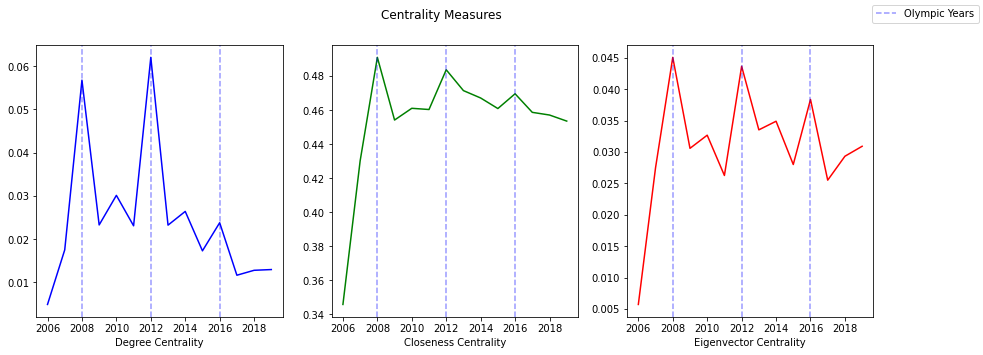

In [ ]:
x = list(range(2006, END_YEAR+1))

measure = ["Degree Centrality", "Closeness Centrality", "Eigenvector Centrality"]
colors = ['b', 'g', 'r']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Centrality Measures')

for i, ax in enumerate(axs):
  ax.plot(x, stats[measure[i]][1:], color = colors[i])
  ax.set(xlabel=measure[i])

  if i==0:
    ax.axvline(x = 2008, color = 'b',linestyle = "dashed", alpha = 0.4, label = "Olympic Years")
  else:
    ax.axvline(x = 2008, color = 'b',linestyle = "dashed", alpha = 0.4)
  ax.axvline(x = 2012, color = 'b',linestyle = "dashed", alpha = 0.4)
  ax.axvline(x = 2016, color = 'b',linestyle = "dashed", alpha = 0.4)

fig.legend()
fig.show()

As hypothesized, there are spikes on each centrality measure during Olympic times.

We also notice that the centrality increase in 2016 is less than in previous years which might be related to the large number of videos in 2016 compared to the other two years, we leave the analysis of this observation to the next milestone.

This case study suggests that our method of popularity and centrality analysis for trending tags is feasible and can be extended to the whole dataset. Moreover, we will also visualize the tag graphs and we will check the characteristics of trending tags over time.